C:\Users\USER\AppData\Local\Temp\ipykernel_56008\3237920098.py:78: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(MODEL_PATH, map_location=DE


Test Accuracy: 77.35%

Classification Report:
                            precision    recall  f1-score   support

         Actinic keratosis       0.86      0.60      0.71        20
         Atopic Dermatitis       1.00      0.90      0.95        21
          Benign keratosis       0.95      0.95      0.95        20
            Dermatofibroma       0.87      0.65      0.74        20
         Melanocytic nevus       0.60      0.75      0.67        20
                  Melanoma       0.44      0.35      0.39        20
   Squamous cell carcinoma       0.50      0.80      0.62        20
Tinea Ringworm Candidiasis       0.95      1.00      0.98        20
           Vascular lesion       1.00      0.95      0.97        20

                  accuracy                           0.77       181
                 macro avg       0.80      0.77      0.77       181
              weighted avg       0.80      0.77      0.78       181


Confusion matrix saved to: C:\Users\USER\Downloads\data\skin\weig

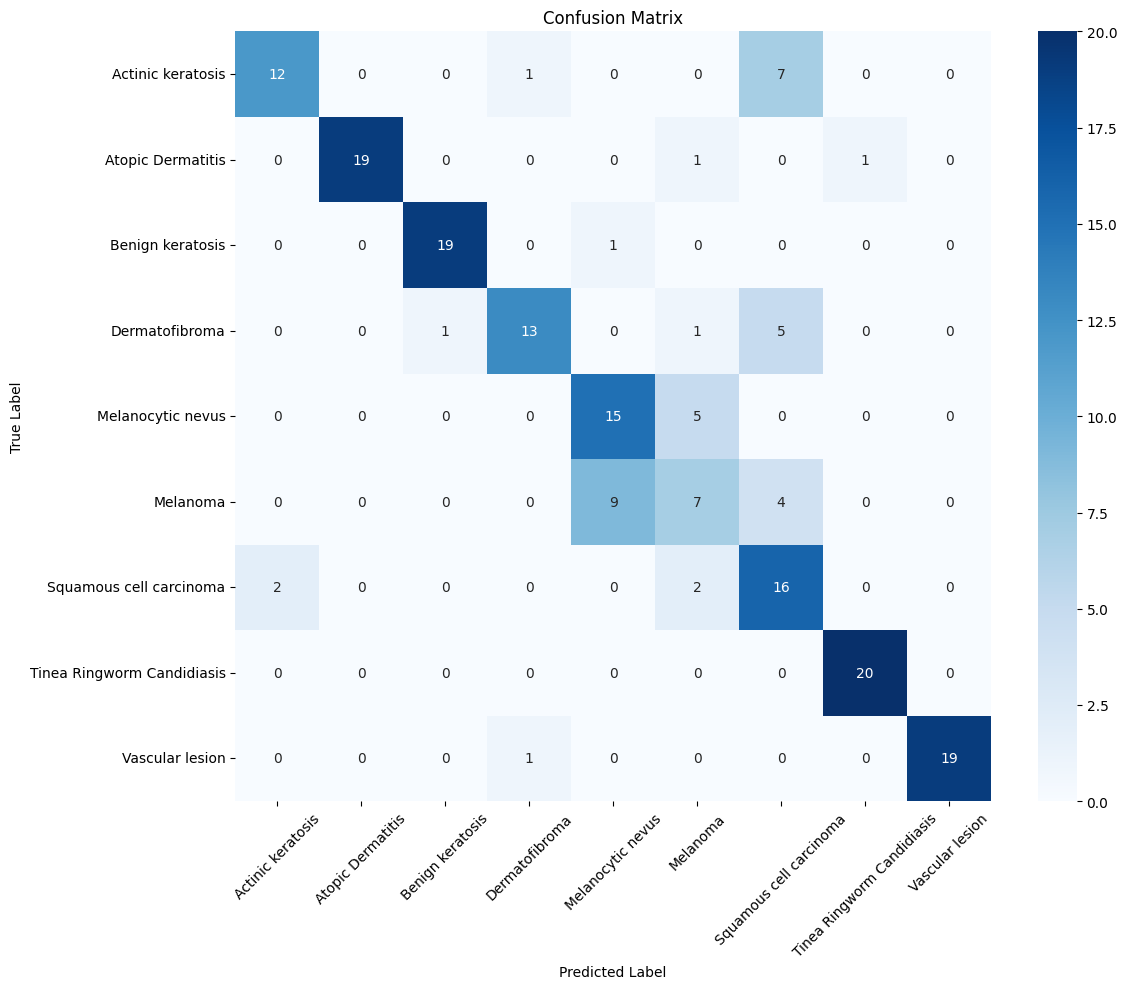

In [6]:
import os
import time
import numpy as np
from PIL import Image
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms, models
from tqdm import tqdm
from sklearn.metrics import classification_report
from torch.utils.tensorboard import SummaryWriter

# ==== CONFIGURATION ====
TEST_DIR = r'C:\Users\USER\Downloads\data\skin\val'  # Path to test dataset
MODEL_PATH = r'C:\Users\USER\Downloads\data\skin\weights\run-20250420-223150\best_epoch5_acc87.86.pth'  # Path to saved model
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32
NUM_CLASSES = 9
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ==== TRANSFORMS ====
test_transform = transforms.Compose([
    transforms.Resize(IMAGE_SIZE),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# ==== DATASET ====
class SkinLesionTestDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.transform = transform
        self.classes = sorted(os.listdir(root_dir))
        self.class_to_idx = {cls: i for i, cls in enumerate(self.classes)}
        self.samples = []
        
        for cls in self.classes:
            cls_dir = os.path.join(root_dir, cls)
            for fname in os.listdir(cls_dir):
                if fname.lower().endswith(('.png', '.jpg', '.jpeg')):
                    self.samples.append((
                        os.path.join(cls_dir, fname),
                        self.class_to_idx[cls]
                    ))

    def __len__(self): return len(self.samples)

    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        img = Image.open(img_path).convert('RGB')
        return self.transform(img), label

# ==== MODEL ARCHITECTURE ====
class ResNetClassifier(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        base = models.resnet18(weights=None)
        self.features = nn.Sequential(*list(base.children())[:-1])
        self.classifier = nn.Sequential(
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.features(x).flatten(1)
        return self.classifier(x)

# ==== TEST FUNCTION ====
def test_model():
    # Load dataset
    test_dataset = SkinLesionTestDataset(TEST_DIR, transform=test_transform)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)
    
    # Load model
    model = ResNetClassifier(NUM_CLASSES).to(DEVICE)
    model.load_state_dict(torch.load(MODEL_PATH, map_location=DEVICE))
    model.eval()
    
    # Testing loop
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for inputs, labels in tqdm(test_loader, desc="Testing"):
            inputs = inputs.to(DEVICE)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.numpy())
    
    # Generate metrics
    accuracy = np.mean(np.array(all_preds) == np.array(all_labels))
    class_names = test_dataset.classes
    
    print(f"\nTest Accuracy: {accuracy*100:.2f}%")
    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds, target_names=class_names))
    
    # Generate confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.tight_layout()
    
    # Save results
    results_dir = os.path.join(os.path.dirname(MODEL_PATH), 'test_results')
    os.makedirs(results_dir, exist_ok=True)
    
    # Save confusion matrix
    cm_path = os.path.join(results_dir, 'confusion_matrix.png')
    plt.savefig(cm_path)
    print(f"\nConfusion matrix saved to: {cm_path}")
    
    # Save classification report
    report_path = os.path.join(results_dir, 'classification_report.txt')
    with open(report_path, 'w') as f:
        f.write(f"Test Accuracy: {accuracy*100:.2f}%\n\n")
        f.write(classification_report(all_labels, all_preds, target_names=class_names))
    print(f"Classification report saved to: {report_path}")
    
    plt.show()


test_model()

C:\Users\USER\AppData\Local\Temp\ipykernel_56008\394149609.py:78: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(MODEL_PATH, map_location=DEV


Test Accuracy: 89.44%

Classification Report:
                            precision    recall  f1-score   support

         Actinic keratosis       0.80      0.60      0.69        20
         Atopic Dermatitis       1.00      1.00      1.00        21
          Benign keratosis       1.00      0.95      0.97        20
            Dermatofibroma       0.81      0.85      0.83        20
         Melanocytic nevus       0.87      1.00      0.93        20
   Squamous cell carcinoma       0.68      0.75      0.71        20
Tinea Ringworm Candidiasis       1.00      1.00      1.00        20
           Vascular lesion       1.00      1.00      1.00        20

                  accuracy                           0.89       161
                 macro avg       0.90      0.89      0.89       161
              weighted avg       0.90      0.89      0.89       161


Confusion matrix saved to: C:\Users\USER\Downloads\data\skin\weights\run-20250420-234143\test_results\confusion_matrix.png
Classifica

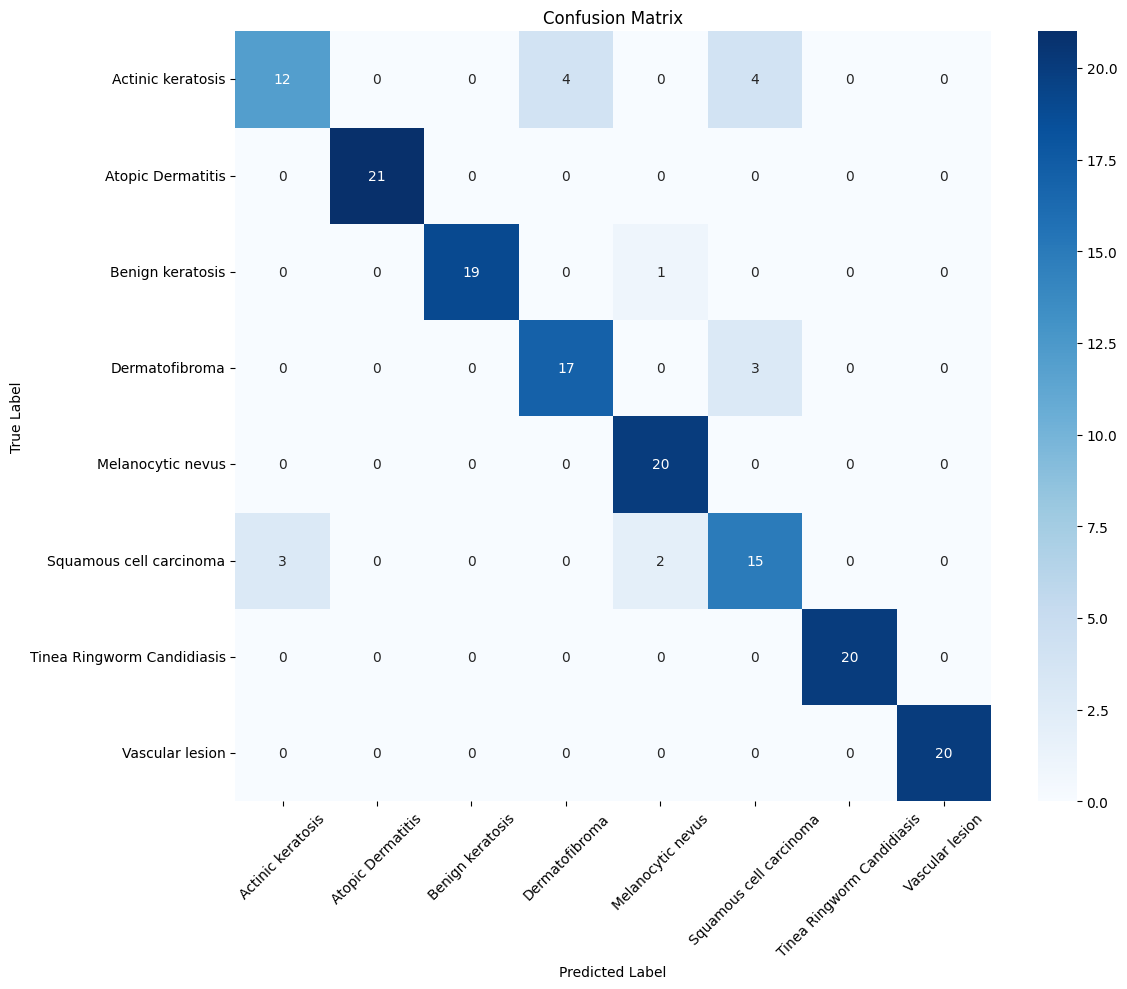

In [7]:
import os
import time
import numpy as np
from PIL import Image
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms, models
from tqdm import tqdm
from sklearn.metrics import classification_report
from torch.utils.tensorboard import SummaryWriter

# ==== CONFIGURATION ====
TEST_DIR = r'C:\Users\USER\Downloads\data\skin\vall'  # Path to test dataset
MODEL_PATH = r'C:\Users\USER\Downloads\data\skin\weights\run-20250420-234143\best_epoch10_acc93.55.pth'  # Path to saved model
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32
NUM_CLASSES = 8
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ==== TRANSFORMS ====
test_transform = transforms.Compose([
    transforms.Resize(IMAGE_SIZE),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# ==== DATASET ====
class SkinLesionTestDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.transform = transform
        self.classes = sorted(os.listdir(root_dir))
        self.class_to_idx = {cls: i for i, cls in enumerate(self.classes)}
        self.samples = []
        
        for cls in self.classes:
            cls_dir = os.path.join(root_dir, cls)
            for fname in os.listdir(cls_dir):
                if fname.lower().endswith(('.png', '.jpg', '.jpeg')):
                    self.samples.append((
                        os.path.join(cls_dir, fname),
                        self.class_to_idx[cls]
                    ))

    def __len__(self): return len(self.samples)

    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        img = Image.open(img_path).convert('RGB')
        return self.transform(img), label

# ==== MODEL ARCHITECTURE ====
class ResNetClassifier(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        base = models.resnet18(weights=None)
        self.features = nn.Sequential(*list(base.children())[:-1])
        self.classifier = nn.Sequential(
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.features(x).flatten(1)
        return self.classifier(x)

# ==== TEST FUNCTION ====
def test_model():
    # Load dataset
    test_dataset = SkinLesionTestDataset(TEST_DIR, transform=test_transform)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)
    
    # Load model
    model = ResNetClassifier(NUM_CLASSES).to(DEVICE)
    model.load_state_dict(torch.load(MODEL_PATH, map_location=DEVICE))
    model.eval()
    
    # Testing loop
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for inputs, labels in tqdm(test_loader, desc="Testing"):
            inputs = inputs.to(DEVICE)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.numpy())
    
    # Generate metrics
    accuracy = np.mean(np.array(all_preds) == np.array(all_labels))
    class_names = test_dataset.classes
    
    print(f"\nTest Accuracy: {accuracy*100:.2f}%")
    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds, target_names=class_names))
    
    # Generate confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.tight_layout()
    
    # Save results
    results_dir = os.path.join(os.path.dirname(MODEL_PATH), 'test_results')
    os.makedirs(results_dir, exist_ok=True)
    
    # Save confusion matrix
    cm_path = os.path.join(results_dir, 'confusion_matrix.png')
    plt.savefig(cm_path)
    print(f"\nConfusion matrix saved to: {cm_path}")
    
    # Save classification report
    report_path = os.path.join(results_dir, 'classification_report.txt')
    with open(report_path, 'w') as f:
        f.write(f"Test Accuracy: {accuracy*100:.2f}%\n\n")
        f.write(classification_report(all_labels, all_preds, target_names=class_names))
    print(f"Classification report saved to: {report_path}")
    
    plt.show()


test_model()

C:\Users\USER\AppData\Local\Temp\ipykernel_56008\1831293392.py:78: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(MODEL_PATH, map_location=DE


Test Accuracy: 83.23%

Classification Report:
                            precision    recall  f1-score   support

         Actinic keratosis       0.50      0.85      0.63        20
         Atopic Dermatitis       1.00      1.00      1.00        21
          Benign keratosis       1.00      1.00      1.00        20
            Dermatofibroma       0.83      0.50      0.62        20
         Melanocytic nevus       0.90      0.95      0.93        20
   Squamous cell carcinoma       0.57      0.40      0.47        20
Tinea Ringworm Candidiasis       1.00      1.00      1.00        20
           Vascular lesion       1.00      0.95      0.97        20

                  accuracy                           0.83       161
                 macro avg       0.85      0.83      0.83       161
              weighted avg       0.85      0.83      0.83       161


Confusion matrix saved to: C:\Users\USER\Downloads\data\skin\weights\run-20250420-234143\test_results\confusion_matrix.png
Classifica

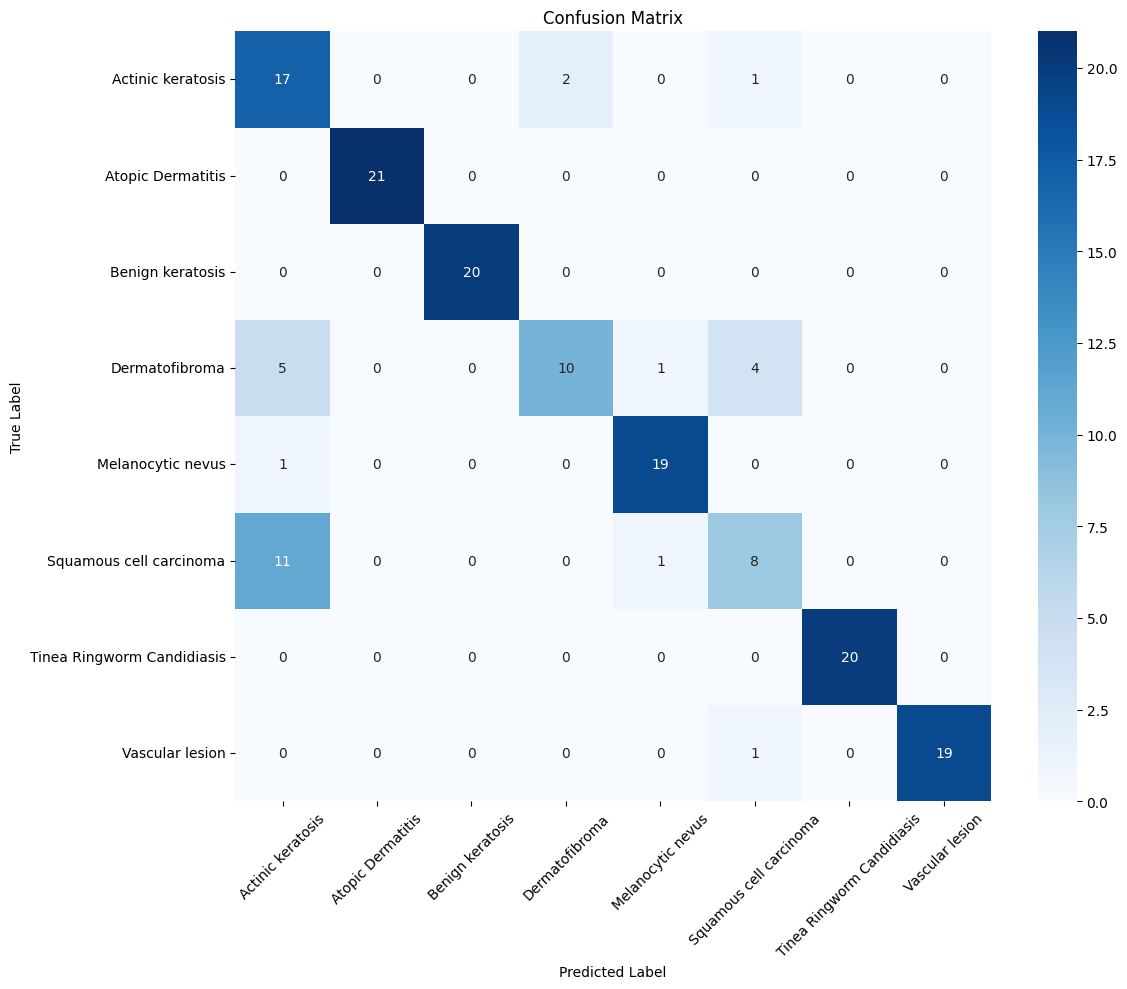

In [11]:
import os
import time
import numpy as np
from PIL import Image
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms, models
from tqdm import tqdm
from sklearn.metrics import classification_report
from torch.utils.tensorboard import SummaryWriter

# ==== CONFIGURATION ====
TEST_DIR = r'C:\Users\USER\Downloads\data\skin\vall'  # Path to test dataset
MODEL_PATH = r'C:\Users\USER\Downloads\data\skin\weights\run-20250420-234143\best_epoch8_acc91.13.pth'  # Path to saved model
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32
NUM_CLASSES = 8
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ==== TRANSFORMS ====
test_transform = transforms.Compose([
    transforms.Resize(IMAGE_SIZE),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# ==== DATASET ====
class SkinLesionTestDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.transform = transform
        self.classes = sorted(os.listdir(root_dir))
        self.class_to_idx = {cls: i for i, cls in enumerate(self.classes)}
        self.samples = []
        
        for cls in self.classes:
            cls_dir = os.path.join(root_dir, cls)
            for fname in os.listdir(cls_dir):
                if fname.lower().endswith(('.png', '.jpg', '.jpeg')):
                    self.samples.append((
                        os.path.join(cls_dir, fname),
                        self.class_to_idx[cls]
                    ))

    def __len__(self): return len(self.samples)

    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        img = Image.open(img_path).convert('RGB')
        return self.transform(img), label

# ==== MODEL ARCHITECTURE ====
class ResNetClassifier(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        base = models.resnet18(weights=None)
        self.features = nn.Sequential(*list(base.children())[:-1])
        self.classifier = nn.Sequential(
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.features(x).flatten(1)
        return self.classifier(x)

# ==== TEST FUNCTION ====
def test_model():
    # Load dataset
    test_dataset = SkinLesionTestDataset(TEST_DIR, transform=test_transform)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)
    
    # Load model
    model = ResNetClassifier(NUM_CLASSES).to(DEVICE)
    model.load_state_dict(torch.load(MODEL_PATH, map_location=DEVICE))
    model.eval()
    
    # Testing loop
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for inputs, labels in tqdm(test_loader, desc="Testing"):
            inputs = inputs.to(DEVICE)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.numpy())
    
    # Generate metrics
    accuracy = np.mean(np.array(all_preds) == np.array(all_labels))
    class_names = test_dataset.classes
    
    print(f"\nTest Accuracy: {accuracy*100:.2f}%")
    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds, target_names=class_names))
    
    # Generate confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.tight_layout()
    
    # Save results
    results_dir = os.path.join(os.path.dirname(MODEL_PATH), 'test_results')
    os.makedirs(results_dir, exist_ok=True)
    
    # Save confusion matrix
    cm_path = os.path.join(results_dir, 'confusion_matrix.png')
    plt.savefig(cm_path)
    print(f"\nConfusion matrix saved to: {cm_path}")
    
    # Save classification report
    report_path = os.path.join(results_dir, 'classification_report.txt')
    with open(report_path, 'w') as f:
        f.write(f"Test Accuracy: {accuracy*100:.2f}%\n\n")
        f.write(classification_report(all_labels, all_preds, target_names=class_names))
    print(f"Classification report saved to: {report_path}")
    
    plt.show()


test_model()